# Курсовой проект Real Estate Price Prediction

In [209]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from warnings import filterwarnings
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

filterwarnings('ignore')
sns.set()
%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [211]:
TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'
TRAIN_DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'

test = pd.read_csv(TEST_DATASET_PATH)
train = pd.read_csv(TRAIN_DATASET_PATH)

train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)

In [212]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [213]:
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [214]:
train.shape, test.shape

((10000, 19), (5000, 18))

In [215]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [216]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


### Обработка категориальных признаков

In [217]:
train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [218]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})
test[feature_bin_names] = test[feature_bin_names].replace({'A':0, 'B':1})

### Анализируем Price

In [219]:
train['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64


 mu = 214138.86 and sigma = 92867.65



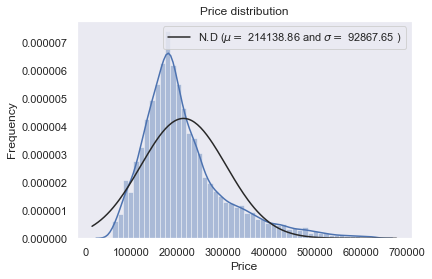

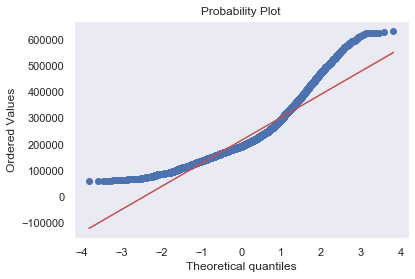

Skewness: 1.366878
Kurtosis: 2.249410


In [220]:
sns.distplot(train['Price'] , fit=norm);

# Сравниваем распределение цен с нормальным распределением без особой практической ценности для проекта, но с красивыми
# графиками.
(mu, sigma) = norm.fit(train['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['N.D ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')
plt.grid()
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)

plt.grid()
plt.show()

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

In [221]:
# Scewness - показывает что распределение значительно положительно скошено вправо, а kurtosis сообщает что распределение 
# меньше нормального, соответственно меньшим пиком и более тонкими краями.

### Анализируем признаки и избавляемся от выбросов

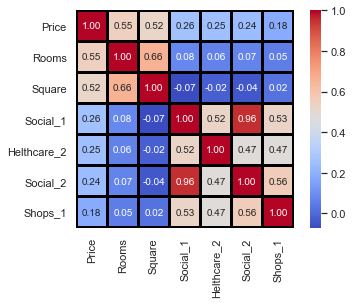

In [222]:
# Матрица корреляции для 7 самых значимых признаков
corrmat = train.corr()
k = 7
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values, cmap= 'coolwarm', linewidths=2, linecolor='black')
plt.show()

In [223]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Самые коррелирующие признаки']
most_corr

,Самые коррелирующие признаки
0,Price
1,Rooms
2,Square
3,Social_1
4,Helthcare_2
5,Social_2
6,Shops_1


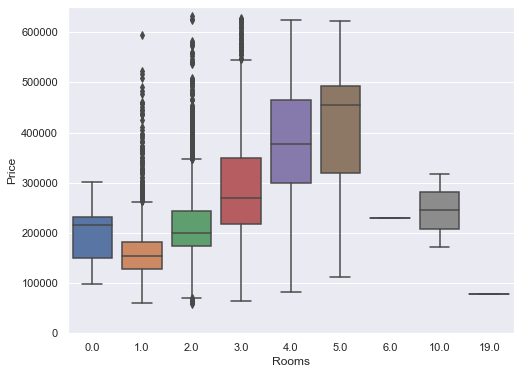

In [224]:
# Проанализируем признаки в отдельности
# Rooms по отношению к Price
var = 'Rooms'
data = pd.concat([train['Price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=650000);

In [225]:
# Есть явные ошибки в данных, посмотрим на количество таких записей.
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [226]:
# Удаляю где количество выходит за пределы основного диапазона.
train = train.drop(train[(train['Rooms']<1) | (train['Rooms']>5)].index)

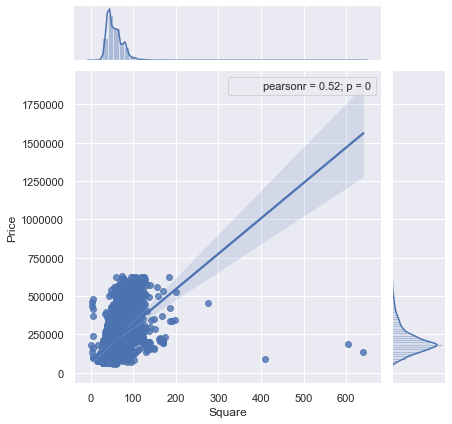

In [227]:
# Square по отношению к Price
sns.jointplot(x=train['Square'], y=train['Price'], kind='reg').annotate(stats.pearsonr)

In [228]:
# Закономерная зависимость в отношении цена-площадь, плюс некоторое количество выбросов, от которых буду избавляться.

In [229]:
# Удаляю всё что больше 160 по площади при цене меньше 250000
train = train.drop(train[(train['Square']>160) 
                         & (train['Price']<250000)].index)
# Так же всё что меньше 10 по площади при цене выше 90000
train = train.drop(train[(train['Square']<10) 
                         & (train['Price']>90000)].index)
# Коэффициент Пирсона вырос

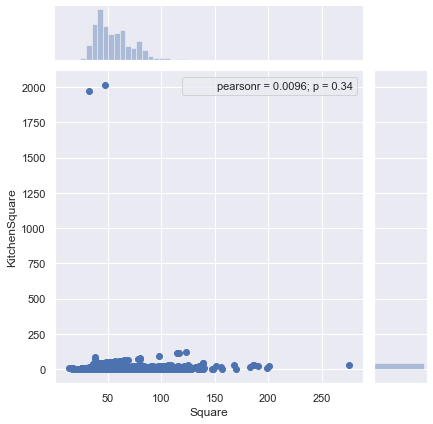

In [230]:
# Кухни к общей площади. Выбросы в кухнях
sns.jointplot(x=train['Square'], y=train['KitchenSquare'], kind='scatter').annotate(stats.pearsonr)

In [231]:
train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,9964.000000,7860.000000,9964.000000
mean,56.093475,36.984881,6.285227
std,18.680244,85.916276,28.610667
min,13.784865,0.370619,0.000000
25%,41.783182,22.798130,1.000000
50%,52.502558,32.766417,6.000000
75%,65.875637,45.098379,9.000000
max,275.645284,7480.592129,2014.000000


### Обработка пропусков и ещё выбросов

In [232]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, train):
        self.medians = train.median()
    
    def transform(self, train):
    
        # KitchenSquare
        train.loc[(train['KitchenSquare'] < 5) | \
             (train['KitchenSquare'] > 30),
             'KitchenSquare'] = train['KitchenSquare'].median()
        
        # Заполнение пропусков в LifeSquare
        train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = train['Square'] - train['KitchenSquare'] - 5
        
        # Изменение LifeSquare
        train.loc[(train['LifeSquare'] > 160) & \
             (train['Square'] < train['LifeSquare']),
             'LifeSquare'] = train['Square'] - train['KitchenSquare'] - 5 
        # Изменение Square
        train.loc[(train['Square'] < train['LifeSquare'] + \
                   train['KitchenSquare']), 'Square'] = train['LifeSquare'] + train['KitchenSquare'] + 5
        # Изменение LifeSquare ещё раз
        train.loc[(train['LifeSquare'] < 20) & \
              (train['Square'] > train['LifeSquare']), 'LifeSquare'] = train['Square'] - train['KitchenSquare'] - 5
 
        # HouseFloor, Floor
        train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] = train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        train.loc[train['HouseYear'] > current_year, 'HouseYear'] = train['HouseYear'].median()
        
        # Healthcare_1
        if 'Healthcare_1' in train.columns:
            train.drop('Healthcare_1', axis=1, inplace=True)
            
        
        
        return train

In [233]:
imputer = FeatureImputer()

imputer.fit(train) # расчет медиан
# Преобразование датасетов
train = imputer.transform(train)
test = imputer.transform(test)

### Построение новых признаков

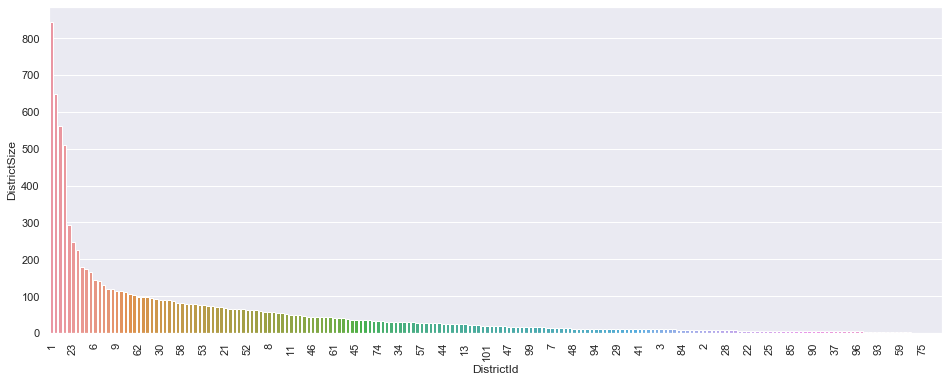

In [234]:
# Понятное дело размер района
district_size = train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [235]:
# 50 использовал, 100 показалось многовато
districts_popular = district_size.loc[district_size['DistrictSize'] > 50, 'DistrictId'].tolist()

In [236]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)

In [237]:
train.loc[~train['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test.loc[~test['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [238]:
train = train.merge(district_size, on='DistrictId', how='left').set_index(train.index)
test = test.merge(district_size, on='DistrictId', how='left').set_index(test.index)

In [239]:
# Цена квадратного метра
train['PriceOneSquaredMeter'] = train['Price'] / train['Square']

In [240]:
# Цена квадратного метра в зависимости от района
price_by_district = train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneSquaredMeter':'median'})\
                        .rename(columns={'PriceOneSquaredMeter':'PriceOneSquaredMeterByDistrict'})

train = train.merge(price_by_district, on=['DistrictId'], how='left').set_index(train.index)
test = test.merge(price_by_district, on=['DistrictId'], how='left').set_index(test.index)

### Отбор признаков и построение модели

In [241]:
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price',
             'DistrictSize',
#             PriceOneSquaredMeter,
             'PriceOneSquaredMeterByDistrict',
]

In [242]:
X = train[feature_names]
y = train.Price.values

X_test = test[feature_names]

In [243]:
# Гибридная модель
model1 = GradientBoostingRegressor(n_estimators=500, max_depth=5, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)

model2 = RandomForestRegressor(n_estimators=500, max_depth=18, random_state=42, max_features=7)

main_model = VotingRegressor([('model1', model1), ('model2', model2)])

In [244]:
main_model.fit(X, y)

VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                

In [201]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(main_model, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.75536


### Прогноз и его выгрузка

In [245]:
y_pred = main_model.predict(X_test)

preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred

preds.to_csv('ESBondarenko_predictions.csv', index=False)